In [32]:
%run "D:\Studium\MA Runde 2\02a Simulationen\02 Freundlich Basismodel\utils_freundlich_NilsV2.ipynb"
%run "D:\Studium\MA Runde 2\02a Simulationen\02 Freundlich Basismodel\VerteilungsfunktionV5.ipynb"

All good


In [33]:
c_feed = [6.865]#6.865                       
n_bound = [1]            
t_in_seconds =19099238#13477635*2                        
n_col= 150

volume_flow_rate = 4.71e-5   

k_RL = [0.000833]    #8.374e-4   

resolution = int(t_in_seconds/3600)
adsorption_parameters = Dict()
adsorption_parameters.is_kinetic = 1
adsorption_parameters.FLDF_KKIN = [0.000003]                                  
adsorption_parameters.FLDF_KF = [43634.176]             
adsorption_parameters.FLDF_N = [2.434308]                     
k_film = [0.006477]   #2.970e-6                                #2.970e-6
porediffusion=3.314470e-10
k_RL=[8.374e-4]
folder= 'Distribution models'
size_distribution=None #folder+'/''GroeßenVerteilung_Ruhl_GAC#A'
porosity_distribution= None #folder+'/'+'SyntheticNormaldist_porosity_0.05_0.55'
axial_distribution=None
vol_frac, sizeclasses,porosityclasses, n_partype = CADETInputs(n_col,size_distribution,porosity_distribution,axial_distribution)

Homogener Fall


In [34]:
def create_column_GRM_varying_col_porosity(t_in_seconds,n_col,  n_bound,n_partype, c_feed, adsorption_parameters, resolution, sizeclasses, porosityclasses ,vol_frac, porediffusion=1,k_film=[2.970e-6] ,
                             k_RL=[8.374e-4],n_columns=1, volume_flow_rate = 4.71e-5 ):
    
    t_in_minutes = t_in_seconds / 60
    t_in_hours = t_in_minutes / 60
    
    n_comp = len(c_feed)                               
   

    model = get_cadet_template(n_columns+2)
    
    
    #########################################  INLET  ###########################################################
    model.root.input.model.unit_000.unit_type = 'INLET'
    model.root.input.model.unit_000.ncomp = n_comp                     
    model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'
    
    model.root.input.model.unit_000.sec_000.const_coeff = c_feed               # mol/m^3
    vol_frac_sliced=[]
    n_col_sliced = int(n_col/n_columns)
    n_col_per_column=[]
    if vol_frac !=[1]:
        vol_frac=np.array(vol_frac).reshape(n_col,n_partype)
        for j in range(n_columns):
            if j == n_columns-1:
                dingus= vol_frac[(j)*n_col_sliced:, :]
                n_col_per_column.append(len(dingus))
                vol_frac_sliced.append(dingus)
            else:        
                dingus= vol_frac[j*n_col_sliced:-(n_col-(j+1)*n_col_sliced), :]
                n_col_per_column.append(len(dingus))
                vol_frac_sliced.append(dingus)
    else:
        vol_frac_sliced = np.ones(n_columns)
        for j in range(n_columns):
            if j == n_columns-1:
                n_col_per_column.append(n_col-j*n_col_sliced)
            else:
                n_col_per_column.append(n_col_sliced)
    
    for unit in range(1,n_columns+1):
        ####################################  Column  ################################################################
        model.root.input.model['unit_{0:03d}'.format(unit)].unit_type = 'GENERAL_RATE_MODEL'        
        model.root.input.model['unit_{0:03d}'.format(unit)].ncomp = n_comp               
        model.root.input.model['unit_{0:03d}'.format(unit)].col_length = 2.1/n_columns                          # m      Pit: 2.1
        model.root.input.model['unit_{0:03d}'.format(unit)].col_porosity = 0.45+(unit-1)*0.00                        #        Pit: 0.45       
        model.root.input.model['unit_{0:03d}'.format(unit)].cross_section_area = 0.046                 # m^2    Pit: 0.046
        model.root.input.model['unit_{0:03d}'.format(unit)].velocity = 2.28e-3                         # m/s  Pit: 2.28e-3      #3.25e-3
        model.root.input.model['unit_{0:03d}'.format(unit)].col_dispersion = n_comp*[0]                # m^2/s  Aumeier:
        model.root.input.model['unit_{0:03d}'.format(unit)].init_c = n_comp * [0]                      # mol/m^3 
        model.root.input.model['unit_{0:03d}'.format(unit)].init_q = n_comp *[0]                       


        ##################################Particles###################################################################

        model.root.input.model['unit_{0:03d}'.format(unit)].film_diffusion = k_film                            # m/s
        model.root.input.model['unit_{0:03d}'.format(unit)].film_diffusion_multiplex = 0  
        model.root.input.model['unit_{0:03d}'.format(unit)].par_diffusion = [porediffusion,]                 # m^2 / s (mobile phase)  Vereinfachung da homogene Partikelprosität angenommen 0.555*2.181e-10
        model.root.input.model['unit_{0:03d}'.format(unit)].par_diffusion_multiplex = 0
        model.root.input.model['unit_{0:03d}'.format(unit)].par_surfdiffusion = [0,]                           # m^2 / s (solid phase)
        model.root.input.model['unit_{0:03d}'.format(unit)].par_surfdiffusion_multiplex = 0
        model.root.input.model['unit_{0:03d}'.format(unit)].par_porosity = porosityclasses                            # Pitt: 0.49
        model.root.input.model['unit_{0:03d}'.format(unit)].par_radius = sizeclasses                           # [5.5e-4,4.5e-4,3.5e-4,2.5e-4,1.5e-4]  # m   beachte RADIUS!!!!! Pitt d=1.1mm --> 0,55mm
        model.root.input.model['unit_{0:03d}'.format(unit)].par_type_volfrac = vol_frac_sliced[unit-1].flatten().tolist() 


        ##########################Reaction#########################################################

        model.root.input.model['unit_{0:03d}'.format(unit)].reaction_model_particles = 'MASS_ACTION_LAW'
        model.root.input.model['unit_{0:03d}'.format(unit)].reaction_particle.MAL_KFWD_liquid = k_RL
        #model.root.input.model.unit_001.reaction_particle.MAL_KFWD_solid = [0]

        model.root.input.model['unit_{0:03d}'.format(unit)].reaction_particle.MAL_KBWD_liquid = 0
        #model.root.input.model.unit_001.reaction_particle.MAL_KBWD_solid = [0]

        model.root.input.model['unit_{0:03d}'.format(unit)].reaction_particle.MAL_STOICHIOMETRY_liquid = [-1]    #[-1, 1]  nur wenn zwei Komponenten in c_feed = [6.865, 0] sind, wurde nur einmal verwendet um den DOC Abbau abzubilden
        #model.root.input.model.unit_001.reaction_particle.MAL_STOICHIOMETRY_solid = [-1]

        ###################################  Adsorption  ###############################################################
        model.root.input.model['unit_{0:03d}'.format(unit)].adsorption_model = 'FREUNDLICH_LDF'         
        model.root.input.model['unit_{0:03d}'.format(unit)].adsorption = adsorption_parameters   
        ###################################  Discretization  #############################################################
    
    set_discretization(model, n_bound)
    for unit in range(1,n_columns+1):
        model.root.input.model['unit_{0:03d}'.format(unit)].discretization.ncol = n_col_per_column[unit-1]          
        model.root.input.model['unit_{0:03d}'.format(unit)].discretization.nbound = n_bound  
        model.root.input.model['unit_{0:03d}'.format(unit)].discretization.npartype = n_partype
        model.root.input.model['unit_{0:03d}'.format(unit)].discretization.par_geom = 'SPHERE'           

    
    

    ###########################################  Outlet  ######################################################
    model.root.input.model['unit_{0:03d}'.format(n_columns+1)].unit_type = 'OUTLET'
    model.root.input.model['unit_{0:03d}'.format(n_columns+1)].ncomp = n_comp

    
    ######################################  Sections and Switches  ############################################
    model.root.input.solver.sections.nsec = 1                         
    model.root.input.solver.sections.section_times = [0.0, t_in_seconds]  
    model.root.input.solver.sections.section_continuity = [0]          

    model.root.input.model.connections.nswitches = 1                  
    model.root.input.model.connections.switch_000.section = 0 
    
    connections=[]
    for k in range(n_columns+1):
        connections.append(k)
        connections.append(k+1)
        connections.append(-1)
        connections.append(-1)
        connections.append(volume_flow_rate)
    model.root.input.model.connections.switch_000.connections = connections #[
        
       # 0, 1, -1, -1, volume_flow_rate,                                               
        #1, 2, -1, -1, volume_flow_rate]
    

            #unit_from, unit_to, component_from, component_to, volumetric flow rate
            #unit_000, unit_001, all components, all components, Q
            #unit_001, unit_002, all components, all components, Q
            #-1 = all components from origin and destination unit are connected
            
            
    #######################################  Simulator Settings  ################################################
    
    
    model.root.input.solver.user_solution_times = np.linspace(0, t_in_seconds, resolution)
    
    return model

In [35]:
test1 = create_column_GRM_varying_col_porosity(t_in_seconds,n_col,  n_bound,n_partype, c_feed, adsorption_parameters, resolution, sizeclasses, porosityclasses ,vol_frac, porediffusion,k_film ,
                             k_RL,n_columns=4, volume_flow_rate = 4.71e-5  )

test1.root.input.model

{'nunits': 6,
 'solver': {'gs_type': 1,
  'max_krylov': 0,
  'max_restarts': 10,
  'schur_safety': 1e-08},
 'unit_000': {'unit_type': 'INLET',
  'ncomp': 1,
  'inlet_type': 'PIECEWISE_CUBIC_POLY',
  'sec_000': {'const_coeff': [6.865]}},
 'unit_001': {'unit_type': 'GENERAL_RATE_MODEL',
  'ncomp': 1,
  'col_length': 0.525,
  'col_porosity': 0.45,
  'cross_section_area': 0.046,
  'velocity': 0.00228,
  'col_dispersion': [0],
  'init_c': [0],
  'init_q': [0],
  'film_diffusion': [0.006477],
  'film_diffusion_multiplex': 0,
  'par_diffusion': [3.31447e-10],
  'par_diffusion_multiplex': 0,
  'par_surfdiffusion': [0],
  'par_surfdiffusion_multiplex': 0,
  'par_porosity': [0.555],
  'par_radius': [0.00055],
  'par_type_volfrac': [1.0],
  'reaction_model_particles': 'MASS_ACTION_LAW',
  'reaction_particle': {'MAL_KFWD_liquid': [0.0008374],
   'MAL_KBWD_liquid': 0,
   'MAL_STOICHIOMETRY_liquid': [-1]},
  'adsorption_model': 'FREUNDLICH_LDF',
  'adsorption': {'is_kinetic': 1,
   'FLDF_KKIN': [3e-

In [36]:
test_homogeneous_col_porosity = create_column_GRM_Nette(t_in_seconds,n_col, n_bound,n_partype, c_feed, adsorption_parameters, resolution, sizeclasses, porosityclasses ,vol_frac, porediffusion,k_film ,
                             k_RL, volume_flow_rate , length=2.1)
test_homogeneous_col_porosity.root.input.model

{'nunits': 3,
 'solver': {'gs_type': 1,
  'max_krylov': 0,
  'max_restarts': 10,
  'schur_safety': 1e-08},
 'unit_000': {'unit_type': 'INLET',
  'ncomp': 1,
  'inlet_type': 'PIECEWISE_CUBIC_POLY',
  'sec_000': {'const_coeff': [6.865]}},
 'unit_001': {'unit_type': 'GENERAL_RATE_MODEL',
  'ncomp': 1,
  'col_length': 2.1,
  'col_porosity': 0.45,
  'cross_section_area': 0.046,
  'velocity': 0.00228,
  'col_dispersion': [0],
  'init_c': [0],
  'init_q': [0],
  'film_diffusion': [0.006477],
  'film_diffusion_multiplex': 0,
  'par_diffusion': 3.31447e-10,
  'par_diffusion_multiplex': 0,
  'par_surfdiffusion': [0],
  'par_surfdiffusion_multiplex': 0,
  'par_porosity': [0.555],
  'par_radius': [0.00055],
  'par_type_volfrac': [1],
  'reaction_model_particles': 'MASS_ACTION_LAW',
  'reaction_particle': {'MAL_KFWD_liquid': [0.0008374],
   'MAL_KBWD_liquid': 0,
   'MAL_STOICHIOMETRY_liquid': [-1]},
  'adsorption_model': 'FREUNDLICH_LDF',
  'adsorption': {'is_kinetic': 1,
   'FLDF_KKIN': [3e-06],
 

In [37]:
run_simulation(test1)


Simulation completed successfully


In [39]:
run_simulation(test_homogeneous_col_porosity)

Simulation completed successfully


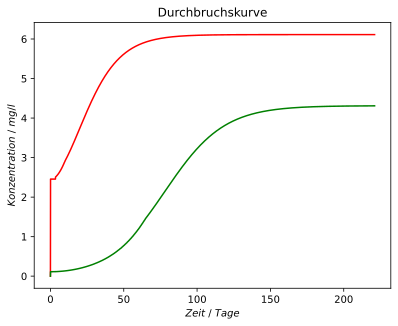

In [40]:
time = test1.root.output.solution.solution_times
c_out =  test1.root.output.solution.unit_001.solution_outlet
time_hom = test_homogeneous_col_porosity.root.output.solution.solution_times
c_out_hom =  test_homogeneous_col_porosity.root.output.solution.unit_001.solution_outlet

plt.figure()
plt.title('Durchbruchskurve')
plt.xlabel('$Zeit~/~Tage$')
plt.ylabel('$Konzentration~/~ mg/l $')
plt.plot(time/86400, c_out, color = 'r', label='$c_{out}$') 
plt.plot(time_hom/86400, c_out_hom, color = 'green', label='$c_{out}$') 